In [2]:
import tensorflow as tf

import os
import time
import numpy as np
import matplotlib.pyplot as plt

use_tpu = True

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
  
bucket_name = 'tf-tpu-estimator-test' #@param {type:"string"}

assert bucket_name, 'Must specify an existing GCS bucket name'
print('Using bucket: {}'.format(bucket_name))

from google.colab import auth
auth.authenticate_user()

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

MODEL_DIR = 'gs://{}/model/tpu/{}'.format(bucket_name, time.strftime('%Y-%m-%d-%H-%M-%S'))
print('Using model dir: {}'.format(MODEL_DIR))

Using bucket: tf-tpu-estimator-test
Using model dir: gs://tf-tpu-estimator-test/model/tpu/2018-11-01-01-15-26


In [0]:
BUFFER_SIZE = 400
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [0]:
def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  if is_train:
    # random jittering
    
    # resizing to 286 x 286 x 3
    input_image = tf.image.resize_images(input_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 x 256 x 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if np.random.random() > 0.5:
      # random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                        align_corners=True, method=2)
    stacked_image = tf.stack([input_image, real_image], axis=0)
    reshape_image = tf.reshape(stacked_image, [2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = reshape_image[0], reshape_image[1]
  
  # normalizing the images to [-1, 1]
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [0]:
def train_input_fn(params):
  dataset = tf.data.Dataset.list_files( 'gs://{}/data/train/*.jpg'.format(bucket_name))
  
  batch_size = params['batch_size']
  dataset = dataset.shuffle(BUFFER_SIZE)
  dataset = dataset.map(lambda x: load_image(x, True))
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.prefetch(1)

  return dataset

def test_input_fn(params):
  dataset = tf.data.Dataset.list_files( 'gs://{}/data/val/1*.jpg'.format(bucket_name))
  
  batch_size = params['batch_size']    
  dataset = dataset.map(lambda x: load_image(x, False))
  dataset = dataset.batch(batch_size, drop_remainder=True)
  dataset = dataset.prefetch(1)

  return dataset

In [0]:
class Pix2pix:
    def __init__(self):
        pass

    def model_fn(self, features, labels, mode, params):
        print(params['batch_size'])
        input_img = tf.reshape(features, [params['batch_size'], 256, 256, 3], name='input_img')
        if mode != tf.estimator.ModeKeys.PREDICT:
            answer_img = tf.reshape(labels, [params['batch_size'], 256, 256, 3], name='answer_img')
        
        def generator(input_data):
            with tf.variable_scope('generator'):
                d1 = tf.layers.conv2d(input_data, 64, 4, 2, padding='same', activation=tf.nn.leaky_relu, name='unet_d1')
                d2 = tf.layers.conv2d(d1, 128, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d2')
                d3 = tf.layers.conv2d(d2, 256, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d3')
                d4 = tf.layers.conv2d(d3, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d4')
                d5 = tf.layers.conv2d(d4, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d5')
                d6 = tf.layers.conv2d(d5, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d6')
                d7 = tf.layers.conv2d(d6, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d7')
                d8 = tf.layers.conv2d(d7, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_d8')
                
                u1 = tf.layers.conv2d_transpose(d8, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u1')
                u1_ = tf.concat([u1, d7], axis=-1)
                u2 = tf.layers.conv2d_transpose(u1_, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u2')
                u2_ = tf.concat([u2, d6], axis=-1)
                u3 = tf.layers.conv2d_transpose(u2_, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u3')
                u3_ = tf.concat([u3, d5], axis=-1)
                u4 = tf.layers.conv2d_transpose(u3_, 512, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u4')
                u4_ = tf.concat([u4, d4], axis=-1)
                u5 = tf.layers.conv2d_transpose(u4_, 256, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u5')
                u5_ = tf.concat([u5, d3], axis=-1)
                u6 = tf.layers.conv2d_transpose(u5_, 128, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u6')
                u6_ = tf.concat([u6, d2], axis=-1)
                u7 = tf.layers.conv2d_transpose(u6_, 64, 4, 2, padding='same', activation=tf.nn.relu, name='unet_u7')
                u7_ = tf.concat([u7, d1], axis=-1)
                
                last = tf.layers.conv2d_transpose(u7_, 3, 4, 2, padding='same', activation=tf.nn.tanh, name='unet_last')
                
                return last

        # Discriminator
        def discriminator(input_data, target_data, reuse=False):
            with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
                con = tf.concat([input_data, target_data], axis=-1)
                l1 = tf.layers.conv2d(con, 16, 3, 3, padding='same', activation=tf.nn.leaky_relu, name='patch_gan_l1')
                l2 = tf.layers.conv2d(l1, 32, 3, 3, padding='same', activation=tf.nn.leaky_relu, name='patch_gan_l2')
                l3 = tf.layers.conv2d(l2, 64, 3, 3, padding='same', activation=tf.nn.leaky_relu, name='patch_gan_l3')
                
                flat = tf.layers.flatten(l3, name='patch_gan_flat')
                d1 = tf.layers.dense(flat, 128, activation=tf.nn.leaky_relu, name='patch_gan_d1')
                dr1 = tf.layers.dropout(d1, rate=0.5, name='patch_gan_dr1')
                d2 = tf.layers.dense(dr1, 16, activation=tf.nn.leaky_relu, name='patch_gan_d2')
                dr2 = tf.layers.dropout(d2, rate=0.5, name='patch_gan_dr2')
                output = tf.layers.dense(dr2, 1, activation=tf.nn.sigmoid, name='patch_gan_output')
            return output

        if mode == tf.estimator.ModeKeys.PREDICT:
            last_unet = generator(input_img)
            predictions = {
                'input': input_img,
                'last_unet': last_unet,
            }
            return  tf.contrib.tpu.TPUEstimatorSpec(mode=mode, predictions=predictions)

        EPS = 1e-12
        last_unet = generator(input_img)
        loss_l1 = tf.losses.mean_squared_error(last_unet, answer_img)
        d1 = discriminator(input_img, answer_img) + EPS
        d2 = discriminator(input_img, last_unet, reuse=True) + EPS
        loss_d = tf.reduce_mean(-(tf.log(d1 + EPS) + tf.log(1 - d2 + EPS)), name='loss_d')
        loss_g_GAN = tf.reduce_mean(-tf.log(d2 + EPS))
        loss_g = tf.add(tf.multiply(loss_l1, 100), loss_g_GAN, name='loss_g')
        loss = loss_d + loss_g

        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'discriminator' in var.name]
        g_vars = [var for var in t_vars if 'generator' in var.name]

        optm_d = tf.train.AdamOptimizer(learning_rate=0.0005)
        optm_g = tf.train.AdamOptimizer(learning_rate=0.001)
        
        optm_d = tf.contrib.tpu.CrossShardOptimizer(optm_d)
        optm_g = tf.contrib.tpu.CrossShardOptimizer(optm_g)

        train_d = optm_d.minimize(loss_d, var_list=d_vars, global_step=tf.train.get_global_step())
        train_g = optm_g.minimize(loss_g, var_list=g_vars, global_step=tf.train.get_global_step())

        tf_group = tf.group([train_d, train_g])

        return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, train_op=tf_group, loss=loss)

In [7]:
tpu_config = tf.contrib.tpu.TPUConfig(num_shards=8, iterations_per_loop=1)

run_config = tf.contrib.tpu.RunConfig(
    save_checkpoints_steps=100,
    save_summary_steps=100,
    master=TF_MASTER,
    model_dir=MODEL_DIR,
    tpu_config=tpu_config)

p = Pix2pix()

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=True,
    model_fn=p.model_fn,
    train_batch_size=TRAIN_BATCH_SIZE,
    predict_batch_size=TEST_BATCH_SIZE,
    config=run_config
)

INFO:tensorflow:Using config: {'_model_dir': 'gs://tf-tpu-estimator-test/model/tpu/2018-11-01-01-15-26', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f95d99ee6d8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': 'grpc://10.42.236.146:8470', '_evaluation_master': 'grpc://10.42.236.146:8470', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_tpu_config': TPUConfig(iterations_per_loop=1, num_shards=8, num_cores_per_replica=None

In [8]:
start = time.time()

estimator.train(
    input_fn=train_input_fn,
    max_steps=100
)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

INFO:tensorflow:Querying Tensorflow master (grpc://10.42.236.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 12476502297688451782)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 3364895950530245070)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 8253173740383586917)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11628952034584227228)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 640699251647932756)
INFO:tensorflow:*** Availabl

In [11]:
pred = list(estimator.predict(input_fn=test_input_fn))

INFO:tensorflow:Calling model_fn.
1
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:TPU job name tpu_worker
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from gs://tf-tpu-estimator-test/model/tpu/2018-11-01-01-15-26/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Init TPU system
INFO:tensorflow:Initialized TPU in 7 seconds
INFO:tensorflow:Starting infeed thread controller.
INFO:tensorflow:Starting outfeed thread controller.
INFO:tensorflow:Initialized dataset iterators in 0 seconds
INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.
INFO:tensorflow:Enqueue next (1) batch(es) of data to infeed.
INFO:tensorflow:Dequeue next (1) batch(es) of data from outfeed.
INFO:tensorflow:Stop infeed thread controller
INFO:tensorflow:Shutting down InfeedController thread.
INFO:tensorflow:InfeedController received shutdown signal

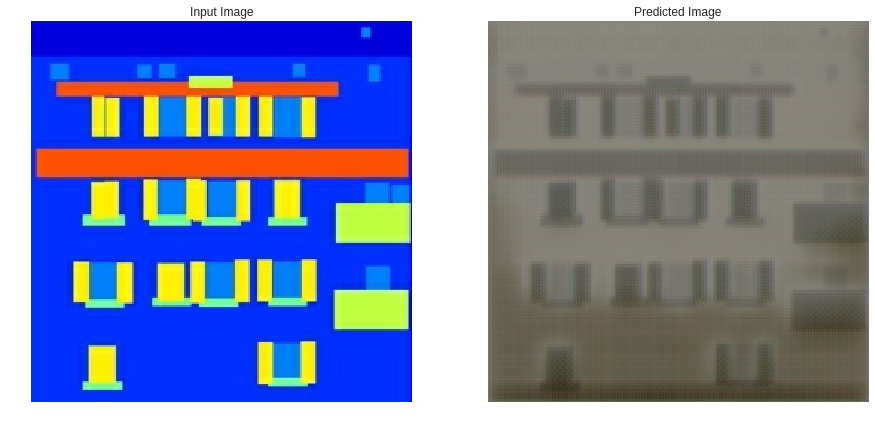

In [12]:
 plt.figure(figsize=(15,15))

display_list = [pred[1]['input'], pred[1]['last_unet']]
title = ['Input Image', 'Predicted Image']

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(title[i])
  plt.imshow(display_list[i] * 0.5 + 0.5)
  plt.axis('off')
plt.show()